I am going to use is Kaggle introduction to NLP dataset. I am going to build classifer to predict which tweets are about real disasters and which ones are not.




I'll start with a baseline model and move on from there


*   Model 0: Naive bayes(baseline)
*   Model 1: Feed_forward neural network (dense model)
*   Model 2: LSTM model (RNN)
*   Model 3: GRU model (RNN)
*   Model 4: Bidirectional-LSTM model(RNN)
*   Model 5: 1D Convolutional Neural Network (CNN)
*   Model 6: Tensorflow Hub Pretrained Feature Extractor (Using Transfer learning for NLP)



In [1]:
## check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-03-16 10:08:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-03-16 10:08:58 (122 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [3]:
!unzip nlp_getting_started.zip -d nlpdataset

Archive:  nlp_getting_started.zip
  inflating: nlpdataset/sample_submission.csv  
  inflating: nlpdataset/test.csv     
  inflating: nlpdataset/train.csv    


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
train = pd.read_csv('/content/nlpdataset/train.csv')
#test = pd.read_csv('/content/nlpdataset/test.csv')
train.head()



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.shape

(7613, 5)

In [6]:
max([len(x) for x in train['text']])

157

In [7]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
# Shuffle the training data 
train_df_shuffled = train.sample(frac=1, random_state=42)

In [9]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# how many sample
len(train_df_shuffled)

7613

In [12]:
# Let us split the data

from sklearn.model_selection import train_test_split
X = train_df_shuffled['text']
y = train_df_shuffled['target']

X_train,X_test, y_train,  y_test =    train_test_split(X, y, train_size=.8, random_state = 42)    

X_train = X_train.values
X_test = X_test.values

In [13]:
X_train.shape, X_test.shape

((6090,), (1523,))

**Evaluation Metrics:**

We are going to use the following evaluations metrics to measure the performance of the models:


*   Accuracy

*   F1 Score

*   Recall
*   Precision







In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
  model_results = {'accuracy':model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'F1': model_f1
                   }
  return model_results

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [16]:
model_0 = Pipeline([
                    
                    ('tfyidf', TfidfVectorizer()),
                    ('MNB', MultinomialNB())
])

In [17]:
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfyidf', TfidfVectorizer()), ('MNB', MultinomialNB())])

In [18]:
pred_0 = model_0.predict(X_test)

In [19]:
mode1_0_results = calculate_results(pred_0, y_test)
mode1_0_results

{'F1': 0.8061459908247106,
 'accuracy': 79.9080761654629,
 'precision': 0.8394056761682985,
 'recall': 0.799080761654629}

**Data Preprocessing**



Create token victorizer to convert the input text into numbers

In [20]:
from tensorflow.keras.layers import TextVectorization

max_vocab = 10000 # max number of words to have 
embedding_dim = 128
max_seq_length = 15 # how many words the model will see for each tweet

text_victorizer = TextVectorization(

                  max_tokens=max_vocab,
                  output_mode="int",
                  output_sequence_length=max_seq_length)
text_victorizer.adapt(X_train)

**Model 1: Simple Dense Model:**

In [21]:
# Create a tensorboard callback


SAVE_DIR = 'model_logs'

In [22]:
# Build model with the functional API
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
X = text_victorizer(inputs)
X = layers.Embedding(max_vocab, embedding_dim)(X)
X = layers.GlobalAveragePooling1D() (X)
outputs = layers.Dense(1, activation='sigmoid')(X)
model_1 = tf.keras.Model(inputs, outputs , name= 'model_1_dense')


In [23]:
model_1.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

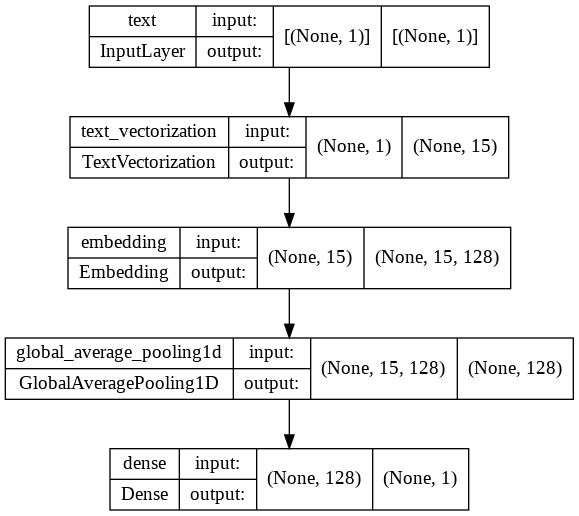

In [24]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [25]:
# fit the model

model_1_hsitory = model_1.fit(x = X_train, 
                              y = y_train,
                              epochs = 5,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/5
191/191 [==============================] - 3s 13ms/step - loss: 0.6192 - accuracy: 0.6880 - val_loss: 0.5474 - val_accuracy: 0.7518
Epoch 2/5
191/191 [==============================] - 2s 12ms/step - loss: 0.4536 - accuracy: 0.8120 - val_loss: 0.4762 - val_accuracy: 0.7820
Epoch 3/5
191/191 [==============================] - 3s 15ms/step - loss: 0.3530 - accuracy: 0.8576 - val_loss: 0.4640 - val_accuracy: 0.7892
Epoch 4/5
191/191 [==============================] - 4s 22ms/step - loss: 0.2861 - accuracy: 0.8883 - val_loss: 0.4634 - val_accuracy: 0.7905
Epoch 5/5
191/191 [==============================] - 4s 21ms/step - loss: 0.2371 - accuracy: 0.9146 - val_loss: 0.4770 - val_accuracy: 0.7925


In [26]:
model_1.evaluate(X_test, y_test)

48/48 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7925


[0.4770023226737976, 0.7925148010253906]

In [27]:
X_test[0:3]

array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
       'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
       'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj'],
      dtype=object)

In [28]:
model_1.predict(X_test[0:3])

array([[0.33840436],
       [0.870498  ],
       [0.99649405]], dtype=float32)

In [29]:
#Convert probabilities into label either 0 or 1
model_1_pred = model_1.predict(X_test)
model_1_pred = np.squeeze(np.round(model_1_pred))

#Evaluate Model 1 :
mode1_1_results = calculate_results(model_1_pred, y_test)
mode1_1_results

{'F1': 0.7961901598045722,
 'accuracy': 79.25147734734077,
 'precision': 0.8103404008646431,
 'recall': 0.7925147734734077}

In [30]:
mode1_0_results

{'F1': 0.8061459908247106,
 'accuracy': 79.9080761654629,
 'precision': 0.8394056761682985,
 'recall': 0.799080761654629}

In [31]:
word_in_vocab = text_victorizer.get_vocabulary()
len(word_in_vocab), word_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [32]:
# get the weights matrix of embedding layer
#emed_weights = model_1.get_layer('embedding_6').get_weights()[0]
#emed_weights.shape

**Model 2: LSTM:**


LSTM = Long short term memory

our stucutre of an RMM will be:

Input (text) -> Toknize -> Embedding -> Layers(RNNs/Dense) -> output


In [33]:
# Create LSTM model


inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
X = text_victorizer(inputs)
X = layers.Embedding(max_vocab, embedding_dim)(X)
#X = layers.GlobalAveragePooling1D() (X)
X = layers.LSTM(64, activation = 'tanh',  return_sequences=True)(X)
X = layers.LSTM(64, activation = 'tanh')(X)

outputs = layers.Dense(1, activation='sigmoid')(X)
model_2 = tf.keras.Model(inputs, outputs , name= 'model_2_LSTM')

In [34]:
model_2.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [35]:
# fit the model

model_2_hsitory = model_2.fit(x = X_train, 
                              y = y_train,
                              epochs = 5,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/5
191/191 [==============================] - 19s 52ms/step - loss: 0.5121 - accuracy: 0.7494 - val_loss: 0.4686 - val_accuracy: 0.7919
Epoch 2/5
191/191 [==============================] - 9s 46ms/step - loss: 0.3087 - accuracy: 0.8747 - val_loss: 0.5330 - val_accuracy: 0.7899
Epoch 3/5
191/191 [==============================] - 8s 41ms/step - loss: 0.2053 - accuracy: 0.9253 - val_loss: 0.5422 - val_accuracy: 0.7800
Epoch 4/5
191/191 [==============================] - 7s 36ms/step - loss: 0.1545 - accuracy: 0.9476 - val_loss: 0.6729 - val_accuracy: 0.7702
Epoch 5/5
191/191 [==============================] - 6s 31ms/step - loss: 0.1050 - accuracy: 0.9621 - val_loss: 0.8809 - val_accuracy: 0.7630


In [36]:
#Convert probabilities into label either 0 or 1
model_2_pred = model_2.predict(X_test)
model_2_pred = np.squeeze(np.round(model_2_pred))

#Evaluate Model 2 :
mode1_2_results = calculate_results(model_2_pred, y_test)
mode1_2_results

{'F1': 0.7635877699150548,
 'accuracy': 76.2967826657912,
 'precision': 0.7646890656428618,
 'recall': 0.762967826657912}

**Model 3: GRU:**


GRU = Gated Recurrent Network

our stucutre of an RNN will be:

Input (text) -> Tokenize -> Embedding -> Layers(RNNs/Dense) -> output


In [37]:
# Create LSTM model


inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
X = text_victorizer(inputs)
X = layers.Embedding(max_vocab, embedding_dim)(X)

X = layers.GRU(64, activation = 'tanh',  return_sequences=True)(X)
X = layers.GRU(64, activation = 'tanh')(X)

outputs = layers.Dense(1, activation='sigmoid')(X)
model_3 = tf.keras.Model(inputs, outputs , name= 'model_2_GRU')

In [38]:
model_3.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_3.summary()

Model: "model_2_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                       

In [39]:
# fit the model

model_3_hsitory = model_3.fit(x = X_train, 
                              y = y_train,
                              epochs = 5,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/5
191/191 [==============================] - 23s 78ms/step - loss: 0.5253 - accuracy: 0.7333 - val_loss: 0.4658 - val_accuracy: 0.7892
Epoch 2/5
191/191 [==============================] - 10s 53ms/step - loss: 0.3118 - accuracy: 0.8731 - val_loss: 0.4827 - val_accuracy: 0.7853
Epoch 3/5
191/191 [==============================] - 10s 53ms/step - loss: 0.2150 - accuracy: 0.9204 - val_loss: 0.5922 - val_accuracy: 0.7899
Epoch 4/5
191/191 [==============================] - 9s 47ms/step - loss: 0.1474 - accuracy: 0.9514 - val_loss: 0.6241 - val_accuracy: 0.7722
Epoch 5/5
191/191 [==============================] - 10s 51ms/step - loss: 0.1171 - accuracy: 0.9616 - val_loss: 0.6061 - val_accuracy: 0.7741


In [40]:
#Convert probabilities into label either 0 or 1
model_3_pred = model_3.predict(X_test)
model_3_pred = np.squeeze(np.round(model_3_pred))

#Evaluate Model 2 :
mode1_3_results = calculate_results(model_3_pred, y_test)
mode1_3_results

{'F1': 0.7746961810069968,
 'accuracy': 77.41300065659883,
 'precision': 0.7757156276353151,
 'recall': 0.7741300065659882}

**Model 4: Bidirectional RNN:**


our stucutre of an RNN will be:

Input (text) -> Tokenize -> Embedding -> Layers(RNNs/Dense) -> output

In [41]:
# Create LSTM model


inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
X = text_victorizer(inputs)
X = layers.Embedding(max_vocab, embedding_dim)(X)

X = layers.Bidirectional(layers.LSTM(64, activation = 'tanh',  return_sequences=True))(X)
X = layers.Bidirectional(layers.LSTM(64, activation = 'tanh'))(X)

outputs = layers.Dense(1, activation='sigmoid')(X)
model_4 = tf.keras.Model(inputs, outputs , name= 'Bidrectional_4_LSTM')

In [42]:
model_4.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_4.summary()

Model: "Bidrectional_4_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                               

In [43]:
# fit the model

model_4_hsitory = model_4.fit(x = X_train, 
                              y = y_train,
                              epochs = 5,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/5
191/191 [==============================] - 18s 55ms/step - loss: 0.5125 - accuracy: 0.7529 - val_loss: 0.4697 - val_accuracy: 0.7879
Epoch 2/5
191/191 [==============================] - 10s 54ms/step - loss: 0.3063 - accuracy: 0.8775 - val_loss: 0.5105 - val_accuracy: 0.7965
Epoch 3/5
191/191 [==============================] - 9s 48ms/step - loss: 0.1924 - accuracy: 0.9294 - val_loss: 0.5826 - val_accuracy: 0.7853
Epoch 4/5
191/191 [==============================] - 10s 52ms/step - loss: 0.1331 - accuracy: 0.9542 - val_loss: 0.6398 - val_accuracy: 0.7656
Epoch 5/5
191/191 [==============================] - 9s 48ms/step - loss: 0.1019 - accuracy: 0.9655 - val_loss: 0.7123 - val_accuracy: 0.7761


In [44]:
#Convert probabilities into label either 0 or 1
model_4_pred = model_4.predict(X_test)
model_4_pred = np.squeeze(np.round(model_4_pred))

#Evaluate Model 4 :
mode1_4_results = calculate_results(model_4_pred, y_test)
mode1_4_results

{'F1': 0.7799301140130972,
 'accuracy': 77.60998030203545,
 'precision': 0.7935119884665449,
 'recall': 0.7760998030203545}

In [45]:
model_4_pred.shape

(1523,)

**Model 5: Conv 1D:**


our stucutre of an RNN will be:

Input (text) -> Tokenize -> Embedding -> Layers(RNNs/Dense) -> output

In [46]:
# Create Conv1D model


inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
X = text_victorizer(inputs)
X = layers.Embedding(max_vocab, embedding_dim)(X)

X = layers.Conv1D(64,4,activation = 'relu')(X)
X = layers.Conv1D(64,4, activation = 'relu')(X)
X = layers.GlobalAveragePooling1D() (X)
outputs = layers.Dense(1, activation='sigmoid')(X)
model_5 = tf.keras.Model(inputs, outputs , name= 'Model_5_CONV1D')

In [47]:
model_5.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_4.summary()

Model: "Bidrectional_4_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                               

In [48]:
# fit the model

model_5_hsitory = model_5.fit(x = X_train, 
                              y = y_train,
                              epochs = 5,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/5
191/191 [==============================] - 5s 25ms/step - loss: 0.5426 - accuracy: 0.7246 - val_loss: 0.4866 - val_accuracy: 0.7814
Epoch 2/5
191/191 [==============================] - 3s 18ms/step - loss: 0.3249 - accuracy: 0.8655 - val_loss: 0.5012 - val_accuracy: 0.7695
Epoch 3/5
191/191 [==============================] - 3s 18ms/step - loss: 0.1973 - accuracy: 0.9227 - val_loss: 0.5946 - val_accuracy: 0.7689
Epoch 4/5
191/191 [==============================] - 4s 20ms/step - loss: 0.1187 - accuracy: 0.9557 - val_loss: 0.7930 - val_accuracy: 0.7623
Epoch 5/5
191/191 [==============================] - 3s 17ms/step - loss: 0.0764 - accuracy: 0.9686 - val_loss: 1.0395 - val_accuracy: 0.7636


In [49]:
#Convert probabilities into label either 0 or 1
model_5_pred = model_5.predict(X_test)
model_5_pred = np.squeeze(np.round(model_5_pred))

#Evaluate Model 5 :
mode1_5_results = calculate_results(model_5_pred, y_test)
mode1_5_results

{'F1': 0.7652152698140466,
 'accuracy': 76.36244254760342,
 'precision': 0.7691778449977296,
 'recall': 0.7636244254760342}

**Model 6: Pretrained layer:**




I will build model using pretrained layer to transfer learning. Pretrained layers can be downloaded or recalled from https://tfhub.dev/google/universal-sentence-encoder/4

In [59]:
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape = [], dtype = tf.string,
                                        name = 'USE')




TensorShape([2, 512])

In [73]:
model_6 = tf.keras.Sequential([
                    sentence_encoder_layer,
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                    ])
                          


In [74]:
model_6.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [75]:
# fit the model

model_6_hsitory = model_6.fit(x = X_train, 
                              y = y_train,
                              epochs = 10,
                              validation_data = (X_test, y_test),
                              callbacks = [tf.keras.callbacks.TensorBoard(log_dir=SAVE_DIR)]
                              )

Epoch 1/10
191/191 [==============================] - 4s 14ms/step - loss: 0.4915 - accuracy: 0.7870 - val_loss: 0.4478 - val_accuracy: 0.7925
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4077 - accuracy: 0.8210 - val_loss: 0.4414 - val_accuracy: 0.8024
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3922 - accuracy: 0.8263 - val_loss: 0.4345 - val_accuracy: 0.8083
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3811 - accuracy: 0.8304 - val_loss: 0.4352 - val_accuracy: 0.8076
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3718 - accuracy: 0.8373 - val_loss: 0.4382 - val_accuracy: 0.8148
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3614 - accuracy: 0.8414 - val_loss: 0.4411 - val_accuracy: 0.8109
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3521 - accuracy: 0.8443 - val_loss: 0.4347 - val_accuracy: 0.8142

In [76]:
#Convert probabilities into label either 0 or 1
model_6_pred = model_6.predict(X_test)
model_6_pred = np.squeeze(np.round(model_6_pred))

#Evaluate Model 6 :
mode1_6_results = calculate_results(model_6_pred, y_test)
mode1_6_results

{'F1': 0.8244999024118981,
 'accuracy': 82.27183191070256,
 'precision': 0.8310693188807714,
 'recall': 0.8227183191070256}

**Summary**

Comparing the performance of all built models

In [82]:
df = pd.DataFrame([mode1_0_results, mode1_1_results, mode1_2_results, mode1_3_results, mode1_4_results, mode1_5_results, mode1_6_results])
df.index.name = 'Model'
df

,accuracy,precision,recall,F1
Model,,,,
0,79.908076,0.839406,0.799081,0.806146
1,79.251477,0.810340,0.792515,0.796190
2,76.296783,0.764689,0.762968,0.763588
3,77.413001,0.775716,0.774130,0.774696
4,77.609980,0.793512,0.776100,0.779930
5,76.362443,0.769178,0.763624,0.765215
6,82.271832,0.831069,0.822718,0.824500
